In [ ]:
# Need to measure the cumulative regret
# Use gaussian process eta[t] = sqrt(1-ro**2)*eta[t-1] + ro*n[t]
# where eta[0] = 1_7, n[t] ~ N(0, I_7), and ro=0.1
# s_t was generated in the same way


In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', None)

import seaborn
plt.style.use(['seaborn-poster'])

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


/Users/rohunkshirsagar/miniconda3/lib/python3.7/site-packages/ipykernel-5.1.3-py3.7.egg/ipykernel_launcher.py:66: RuntimeWarning: covariance is not symmetric positive-semidefinite.


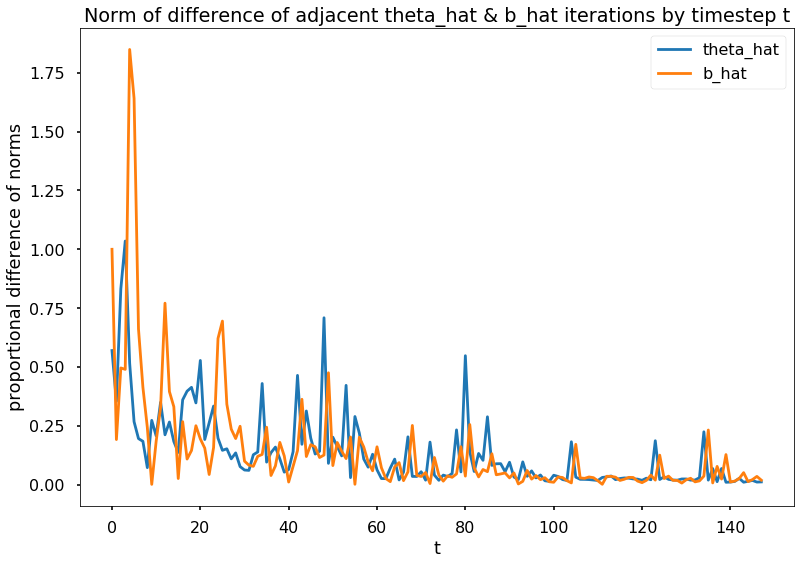

In [266]:
# Simulation

from scipy.stats import norm

d = 7
num_actions = 2
d_prime = d*num_actions

n_idx_sbar = 4

B = np.identity(n_idx_sbar)
theta_hat = np.zeros(n_idx_sbar)
b_hat = np.zeros(n_idx_sbar)

pi_min = 0.2
pi_max = 0.8

num_timesteps = 150

pi = [0]*num_timesteps
pi[0] = np.random.uniform(low=pi_min, high=pi_max)

ro = 0.1
mean = np.zeros(d) 
cov = np.identity(d)

# init
s_bar = [0]*num_timesteps
s_bar[0] = np.ones((d, 1))

eta_bar = [0]*num_timesteps
eta_bar[0] = np.ones((feats_dim, feats_dim))

s_ta = [0]*num_timesteps#np.zeros((num_timesteps, num_actions))

nu = 1
const_theta = [0.116, -0.275, -0.233, 0.425, 0.116, 0.275, -0.233, 0.0425]
reward = [0]*num_timesteps

reward_thresh = 0.8

n = [0]*num_timesteps
ns = [0]*num_timesteps
a = [0]*num_timesteps
s_ta_bar = [0]*num_timesteps

b_ls = []
b_ls.append(b_hat)
s_ls = []
theta_ls = []
for t in range(1, num_timesteps):
    # sample n[t]
    n[t] = np.random.multivariate_normal(mean, cov, 1)
    ns[t] = np.random.multivariate_normal(mean, cov, 1)
    
    # update s_bar (i.e "observe" s_bar)
    s_bar[t] = np.sqrt(1 - ro**2)*s_bar[t-1] + ro*ns[t].reshape(-1, 1)
    
    # Make s_ta
    s_ta[t] = np.array([s_bar[t][:n_idx_sbar] for i in range(num_actions)])
    
    # update eta_bar
    eta_bar[t] = np.sqrt(1 - ro**2)*eta_bar[t-1] + ro*n[t].reshape(-1, 1)
    
    # Sample theta_prime
    theta_prime = np.random.multivariate_normal(theta_hat, nu**2*np.linalg.inv(B), 1)
    
    # Which action is optimal?
    opt_action_idx = np.argmax((s_ta[t]*theta_prime.reshape(-1, 1)).sum(axis=1))
    
    # Prob of taking non-zero action
    cdf = norm.cdf(0,
                   loc=sum((s_bar[t][:n_idx_sbar]*theta_hat.reshape(-1, 1))), 
                   scale=sum((s_bar[t][:n_idx_sbar]*nu**2*np.diagonal(np.linalg.inv(B)).reshape(-1, 1))))
    pi[t] = max(pi_min, min(pi_max, cdf))
    
    # Flip biased coin with prob pi[t]
    outcome = np.random.binomial(1, pi[t])
    
    if outcome:
        a[t] = opt_action_idx
        a_bar_indicator = 1
    else:
        a[t] = 0
        a_bar_indicator = 0
    # Optimal non-zero action
    s_ta_bar[t] = s_ta[t][opt_action_idx]
    
    s = np.linalg.norm(s_bar[t], 1)
    s_ls.append(s)
    if s > 0.8:
        state_indicator = 1
    else:
        state_indicator = 0
    
    
    # Simulated reward
    reward[t] = sum(np.array(const_theta).reshape(1, -1)*np.concatenate(s_ta[t]).reshape(1, -1))[0] + 2*state_indicator + np.random.normal(0, 1)
    # Update b_hat, B, and theta_hat
    B = B + pi[t]*(1 - pi[t])*s_ta_bar[t]*s_ta_bar[t]
    b_hat = (b_hat + np.concatenate(s_ta_bar[t]*(a_bar_indicator - pi[t])*reward[t]))
    b_ls.append(b_hat)
    theta_hat = np.matmul(np.linalg.inv(B), b_hat).ravel()
    theta_ls.append(theta_hat)
# plt.plot(s_ls)

plt.plot([np.linalg.norm(theta_ls[t] - theta_ls[t-1], 1)/np.linalg.norm(theta_ls[t], 1) for t in range(1, num_timesteps-1)], label='theta_hat')
plt.title('Norm of difference of adjacent theta_hat iterations by timestep t')
plt.xlabel('t')
plt.ylabel('proportional difference of norms')

plt.plot([np.linalg.norm(b_ls[t] - b_ls[t-1], 1)/np.linalg.norm(b_ls[t], 1) for t in range(1, num_timesteps-1)], label='b_hat')
plt.title('Norm of difference of adjacent theta_hat & b_hat iterations by timestep t')
plt.xlabel('t')
plt.ylabel('proportional difference of norms')

plt.legend()



In [238]:
theta_ls

[array([0.64564076, 0.6442215 , 0.64562497, 0.64282576]),
 array([0.0915638 , 0.34348923, 0.12652256, 0.00973955]),
 array([0.24218519, 0.4878095 , 0.27953227, 0.17447923]),
 array([-0.03026768,  0.413918  ,  0.07149374, -0.06081228]),
 array([-0.31675364,  0.22132899, -0.04924581, -0.36825357]),
 array([-0.05218304,  0.40295281, -0.02627933, -0.33746384]),
 array([-0.02785136,  0.43895298,  0.0124439 , -0.28864525]),
 array([-0.05242967,  0.25694477, -0.15141871, -0.70406377]),
 array([-0.1220278 , -0.08170242, -0.21584904, -0.81629108]),
 array([ 0.11815868, -0.04831706, -0.17644361, -0.7506512 ]),
 array([ 0.24557868, -0.16414898, -0.34990345, -0.97122424]),
 array([ 0.35583206, -0.20415922, -0.2873822 , -0.81023901]),
 array([ 0.32093398, -0.18483505,  0.1522057 , -0.80673836]),
 array([ 0.29505778,  0.02581838,  0.39255816, -0.90360305]),
 array([ 0.1243495 ,  0.47963562,  0.64017968, -1.05148101]),
 array([-0.45544832,  1.21005509,  1.00549044, -1.10218483]),
 array([-0.85395028,

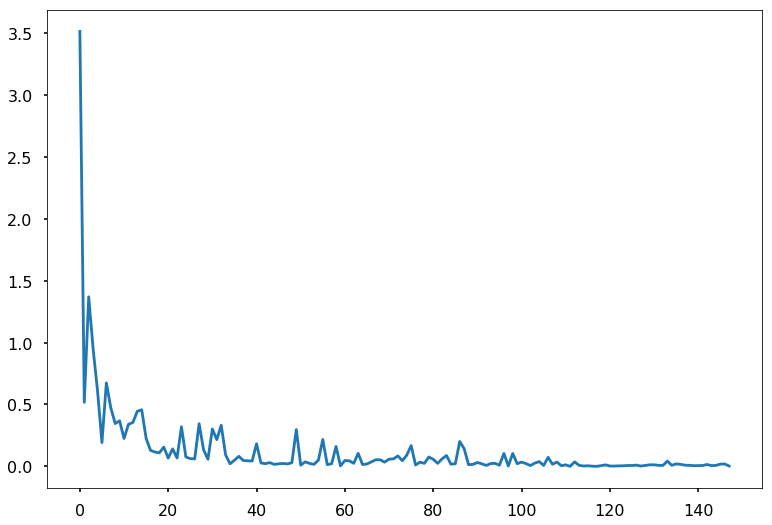

In [243]:
plt.plot([np.linalg.norm(theta_ls[t] - theta_ls[t-1], 1)/np.linalg.norm(theta_ls[t], 1) for t in range(1, num_timesteps-1)])

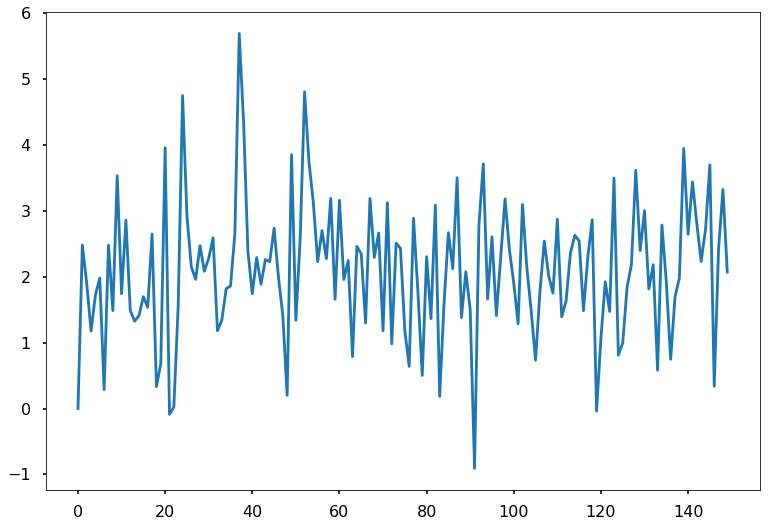

In [222]:
import matplotlib.pyplot as plt

import seaborn
plt.style.use(['seaborn-poster'])

plt.plot(reward)

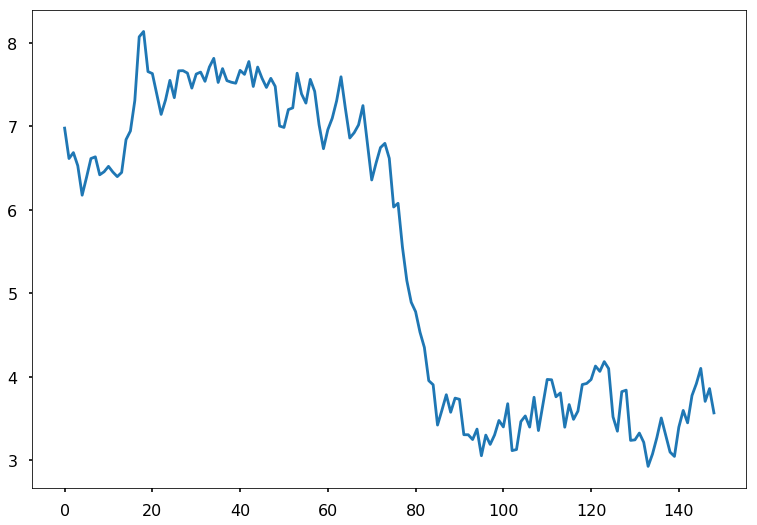

In [223]:
plt.plot(s_ls)

In [220]:
s_ta_bar

[0, array([[0.87417956],
        [0.99901482],
        [0.74152475],
        [0.9311552 ]]), array([[0.93876238],
        [0.91637629],
        [0.76932242],
        [0.85104497]]), array([[0.93329648],
        [0.8982461 ],
        [0.78810731],
        [0.79402224]]), array([[0.73414045],
        [0.820993  ],
        [0.89036044],
        [0.70722965]]), array([[0.77447882],
        [0.88372819],
        [0.93322143],
        [0.79568011]]), array([[0.94496637],
        [0.88687169],
        [0.97365221],
        [0.77999737]]), array([[0.98897757],
        [0.95681639],
        [0.98916758],
        [0.77220083]]), array([[1.00027964],
        [1.02723845],
        [0.96458668],
        [0.7299574 ]]), array([[1.14348583],
        [0.7616506 ],
        [1.01612294],
        [0.54669271]]), array([[1.16710154],
        [1.01967152],
        [0.84511034],
        [0.81803098]]), array([[1.2042997 ],
        [1.10196315],
        [0.86834473],
        [0.87666385]]), array([[1.1425932

In [215]:
b_hat

array([ 6.51250254,  6.53323126, 10.52420213, -8.87539376])

In [141]:
s_ta[t][opt_action_idx]


array([[0.8884339 ],
       [1.36301781],
       [1.08847786],
       [0.88667988]])

In [192]:
np.concatenate(s_ta_bar[t-1]*(a_bar_indicator - pi[t-1])*reward[t-1])

array([-1.65877589, -1.69810603, -1.54156683, -1.14969816])

In [211]:
b_hat

array([[2.72217178],
       [2.8899844 ],
       [2.65691635],
       [2.45391849],
       [2.6544406 ],
       [2.82225322],
       [2.58918517],
       [2.38618731],
       [2.59045644],
       [2.75826905],
       [2.52520101],
       [2.32220315],
       [2.62523104],
       [2.79304366],
       [2.55997561],
       [2.35697775]])

In [191]:
b_hat + np.concatenate(s_ta_bar[t-1]*(a_bar_indicator - pi[t-1])*reward[t-1])

array([[-3.31755178, -3.35688192, -3.20034272, -2.80847405],
       [-3.35688192, -3.39621206, -3.23967286, -2.84780419],
       [-3.20034272, -3.23967286, -3.08313367, -2.691265  ],
       [-2.80847405, -2.84780419, -2.691265  , -2.29939633]])

In [209]:
np.linalg.inv(B).shape, b_hat.shape

((4, 4), (16, 1))

In [207]:
theta_hat.ravel()

array([0.3273839 , 0.32841014, 0.33281676, 0.33396346])

In [144]:
theta_hat

array([[ 0.89464027, -0.1272279 , -0.1272279 , -0.1272279 ],
       [-0.2308323 ,  1.01549739, -0.2308323 , -0.2308323 ],
       [-0.13439548, -0.13439548,  0.90631271, -0.13439548],
       [-0.12451578, -0.12451578, -0.12451578,  0.89003911]])

In [129]:
sum(np.array(const_theta).reshape(-1, 1)*np.concatenate(s_ta[t]).reshape(-1, 1))

array([-0.16790945])

In [131]:
reward

[0,
 3.168522921811207,
 1.6134775813373723,
 1.1533568027995753,
 0.08706120540051598,
 1.2662796569980102,
 -1.792583281789771,
 2.5188194321444937,
 2.3513891881788433,
 0.6156821387791942,
 0.4017891442911863,
 1.3897470170315929,
 2.87634911863178,
 0.7954272553616695,
 0.544341664324383,
 2.4685547856008276,
 1.2247069646483757,
 1.3975542496037272,
 1.3666254873115746,
 2.6546628698293886,
 0.011773661552324288,
 2.708053242457007,
 2.7438294457784878,
 3.9493472353324988,
 2.26200540672399,
 2.957647710384636,
 3.0193882199606907,
 0.5856145736025338,
 0.7840824446404417,
 2.7322160580594015,
 0.06790056900925312,
 1.3409125810641058,
 3.560625809196207,
 2.235353418577622,
 1.9284344490884386,
 2.9252771864490414,
 2.1135606101728714,
 2.2933944157023602,
 3.719164713910022,
 1.059488533765148,
 2.96649014559002,
 1.0137239714569748,
 2.8782279311285706,
 1.1336226944452472,
 1.8239112147233354,
 0.26492360844644636,
 1.591515602366686,
 2.938022625199657,
 2.7143587860357403,

In [83]:
sum(s_bar[t][:n_idx_sbar]*theta_hat.reshape(-1, 1))

array([0.])

In [84]:
sum((s_bar[t][:n_idx_sbar]*nu**2*np.diagonal(np.linalg.inv(B))))

array([4.30508599, 4.30508599, 4.30508599, 4.30508599])

In [88]:
s_bar[t][:n_idx_sbar]*np.diagonal(np.linalg.inv(B)).reshape(-1, 1)

array([[1.02036454],
       [1.10048847],
       [1.07326827],
       [1.11096472]])

In [75]:
(s_bar[t][:n_idx_sbar]*theta_hat.reshape(-1, 1))

array([[0.],
       [0.],
       [0.],
       [0.]])

In [74]:
s_bar[t][:n_idx_sbar].shape, theta_hat.shape

((4, 1), (4,))

In [71]:
np.dot(s_bar[t][:n_idx_sbar], theta_hat.reshape(-1, 1))

ValueError: shapes (4,1) and (4,1) not aligned: 1 (dim 1) != 4 (dim 0)

In [72]:
s_bar[t][:n_idx_sbar].shape, theta_hat.reshape(-1, 1).shape

((4, 1), (4, 1))

In [73]:
s_bar[t][:n_idx_sbar], theta_hat.reshape(-1, 1)

(array([[0.91586813],
        [0.9116161 ],
        [1.01826286],
        [1.04065277]]), array([[0.],
        [0.],
        [0.],
        [0.]]))

In [49]:
pi_max, cdf

(0.8, array([0.5, 0.5, 0.5, 0.5]))

In [27]:
np.random.multivariate_normal(mean, cov, 1)

array([[ 0.81129067, -0.25172729, -0.42220211,  1.44730272, -0.69992564,
        -0.20599458, -0.19639044]])

In [28]:
n[t]

TypeError: 'int' object is not subscriptable

In [23]:
np.argmax((np.array([np.array([1]*7), np.array([2]*7)])*np.array([3]*7)).sum(axis=1))

1

In [24]:
np.random.normal(0, 1)

-0.05793076228496022

In [ ]:
np.argmax((s_ta[t]*theta_prime).sum(axis=1))

In [9]:
a = [0]*5
a[0] = np.ones((3,4))
a

[array([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]]), 0, 0, 0, 0]

In [15]:
np.random.multivariate_normal(mean, cov, 1)

array([[-0.06178533,  1.5015796 ,  0.80188231, -0.51426786, -1.32981744,
        -1.67263918,  0.30084041]])

In [4]:
feats_dim = 7




array([[-0.94447769,  0.21569805, -0.88239   , -0.86723853,  0.59761375,
         0.46337427, -0.02441827],
       [ 0.75036723, -0.23172879, -0.39667197, -1.4956795 , -0.15137306,
         0.32304738, -0.31198404],
       [ 0.12043822, -0.06507172, -0.91318361,  1.18951091, -1.17906455,
         0.61704394,  0.49285484],
       [ 1.22182078, -0.11482288,  0.18394074,  0.25395796,  0.41992941,
        -0.95385997,  1.05320053],
       [ 0.35218806, -1.25994447, -0.32001186, -0.67908014, -0.01323936,
         1.00239005,  0.98795652],
       [-0.21315841,  0.14639679, -0.30612104,  0.17045427,  1.14736222,
        -1.31433193,  1.13225702],
       [ 0.22398357,  0.0813746 , -0.54801935,  0.45991935,  1.67254528,
        -1.61791208,  0.36378681]])